# Fraud Detection Project

# Faz -1 : Data Loading and Cleaning

## 1. Adım: Gerekli Kütüphanelerin Kurulumu

In [5]:
!pip install pandas duckdb pydantic scikit-learn

## 2. Adım: Kütüphaneleri Çağırma ve DuckDB Bağlantısı

DuckDB, Pandas'a göre çok daha az RAM tüketir ve büyük dosyaları SQL hızında işler.

In [5]:
import duckdb
import pandas as pd
from pydantic import BaseModel, Field, validator
from typing import Optional
import numpy as np

# DuckDB bağlantısı (Bellek üzerinde çalışacak)
con = duckdb.connect(database=':memory:')

## 3. Adım: Veri Yükleme (Data Ingestion)

CSV dosyasını DuckDB ile içeri alalım.

In [7]:
# CSV dosyasını DuckDB'ye tablo olarak aktaralım
# 'creditcard.csv' dosyasının dizinini kontrol etmeyi unutma
con.execute("CREATE TABLE raw_transactions AS SELECT * FROM read_csv_auto('creditcard.csv')")

# İlk 5 satıra hızlıca bakalım
df_sample = con.execute("SELECT * FROM raw_transactions LIMIT 5").df()
print(df_sample)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

## 4. Adım: Veri Validasyonu (Pydantic Contracts)

Fraud projelerinde veri girişindeki bir hata, tüm modeli yanıltabilir. Gelen her satırı kontrol edecek bir "sözleşme" yazıyoruz.

In [11]:
class Transaction(BaseModel):
    Time: float
    Amount: float = Field(gt=0) # Tutar 0'dan büyük olmalı
    V1: float # PCA bileşenleri (Veri setindeki isimlendirmeler)
    V2: float
    Class: int # 0: Temiz, 1: Fraud

    @validator('Amount')
    def check_amount(cls, v):
        if v > 20000: # Örnek kural: Tek seferde 20k üstü işlem şüpheli veya veri hatası olabilir
            print(f"Uyarı: Çok yüksek tutarlı işlem: {v}")
        return v

# Örnek test (Hatalı veri girişi denemesi)
try:
    test_txn = Transaction(Time=0.0, Amount=-5.0, V1=1.2, V2=-0.5, Class=0)
except Exception as e:
    print(f"Validasyon Hatası Yakalandı: {e}")

Validasyon Hatası Yakalandı: 1 validation error for Transaction
Amount
  Input should be greater than 0 [type=greater_than, input_value=-5.0, input_type=float]
    For further information visit https://errors.pydantic.dev/2.8/v/greater_than


C:\Users\pc\AppData\Local\Temp\ipykernel_27968\1191171001.py:8: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  @validator('Amount')


**NOT**: Pydantic tam olarak görevini yaparak; Sisteme girmeye çalışan negatif tutarlı hatalı bir işlemi kapıda yakaladı ve içeri almadı.

## 5. Adım: Dengesiz Veri (Imbalance) Analizi

Modeli eğiteceğimiz verinin ne kadar "zehirli" olduğunu görelim.

In [13]:
stats = con.execute("""
    SELECT 
        Class, 
        COUNT(*) as count, 
        100.0 * COUNT(*) / (SELECT COUNT(*) FROM raw_transactions) as percentage
    FROM raw_transactions
    GROUP BY Class
""").df()

print("Sınıf Dağılımı:")
print(stats)

Sınıf Dağılımı:
   Class   count  percentage
0      0  284315   99.827251
1      1     492    0.172749


## 6. Veri Kalite Kontrolü ve Temizlik

### 6.1. Eksik Veri Analizi (Null Check)

Fraud verilerinde NULL değerler modelin çökmesine veya yanlış öğrenmesine neden olur. DuckDB ile tüm kolonları saniyeler içinde tarayalım.

In [17]:
# Her kolon için null değer sayısını kontrol edelim
null_counts = con.execute("""
    SELECT 
        COUNT(*) FILTER (WHERE Time IS NULL) as time_null,
        COUNT(*) FILTER (WHERE Amount IS NULL) as amount_null,
        COUNT(*) FILTER (WHERE Class IS NULL) as class_null,
        -- Diğer V1-V28 kolonları için genel bir kontrol:
        COUNT(*) - COUNT(V1) as v1_null_count
    FROM raw_transactions
""").df()

print("Eksik Veri Raporu:")
print(null_counts)

Eksik Veri Raporu:
   time_null  amount_null  class_null  v1_null_count
0          0            0           0              0


### 6.2. İstatistiksel Anomali Tespiti (Outlier Detection)

Amount (Tutar) kolonunda aşırı uç değerler var mı? Çok yüksek tutarlar genellikle fraud olsa da, bazen veri hatasıdır.

In [20]:
# Tutar kolonunun temel istatistikleri
amount_stats = con.execute("""
    SELECT 
        MIN(Amount) as min_amt,
        MAX(Amount) as max_amt,
        AVG(Amount) as avg_amt,
        STDDEV(Amount) as std_amt
    FROM raw_transactions
""").df()

print("Tutar İstatistikleri:")
print(amount_stats)

Tutar İstatistikleri:
   min_amt   max_amt    avg_amt     std_amt
0      0.0  25691.16  88.349619  250.120109


### 6.3. Veri Temizliği ve Tip Sabitleme (Data Casting)
Eğer NULL değerler varsa onları temizleyip, veriyi "processed" (işlenmiş) tablosuna aktaralım.

In [23]:
# Temizlenmiş veriyi yeni bir tabloya alalım
# Not: Bu örnekte NULL satırları siliyoruz ve Class'ı tam sayıya zorluyoruz.
con.execute("""
    CREATE TABLE processed_transactions AS 
    SELECT 
        CAST(Time AS DOUBLE) as Time,
        CAST(Amount AS DOUBLE) as Amount,
        CAST(Class AS INTEGER) as Class,
        V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, 
        V11, V12, V13, V14, V15, V16, V17, V18, V19, V20,
        V21, V22, V23, V24, V25, V26, V27, V28
    FROM raw_transactions
    WHERE Amount IS NOT NULL AND Class IS NOT NULL
""")

print("Veri temizlendi ve 'processed_transactions' tablosuna aktarıldı.")

Veri temizlendi ve 'processed_transactions' tablosuna aktarıldı.


### 6. 4. İşlenmiş Veriyi Kaydetme

Bu aşamada elde ettiğimiz temiz veriyi bir sonraki notebook'ta kullanmak üzere diske yazalım.
Bu kod bloğu, önce gerekli klasörleri oluşturacak, ardından veriyi güvenli bir şekilde kaydedecektir:

In [26]:
import os

# 1. Klasör yapısını oluştur (Hata almamak için şart)
os.makedirs('data/processed', exist_ok=True)

# 2. DuckDB içindeki tabloyu önce bir Pandas DataFrame'ine alalım 
# (Encoding sorunlarını aşmak için daha esnektir)
df_final = con.execute("SELECT * FROM processed_transactions").df()

# 3. Parquet olarak kaydet (Hızlı ve modern format)
try:
    df_final.to_parquet('data/processed/cleaned_fraud_data.parquet', index=False)
    print("✅ Başarılı: Temizlenmiş veri 'data/processed/cleaned_fraud_data.parquet' olarak kaydedildi!")
except Exception as e:
    print(f"❌ Hata hala devam ediyor: {e}")
    # Eğer yukarıdaki de hata verirse en güvenli liman olan CSV'ye dönelim:
    df_final.to_csv('data/processed/cleaned_fraud_data.csv', index=False, encoding='utf-8')
    print("⚠️ Parquet hatası nedeniyle veri CSV olarak kaydedildi.")

✅ Başarılı: Temizlenmiş veri 'data/processed/cleaned_fraud_data.parquet' olarak kaydedildi!


**Bu Notebook'da yapılanların Özeti:**

- Ham veriyi içeri aldık.

- Pydantic ile veri şemasını doğruladık.

- DuckDB ile eksik ve hatalı verileri ayıkladık.

- Veriyi Parquet formatında (hızlı ve sıkıştırılmış) kaydettik.

----------------------

# Faz 2: Feature Engineering

Verimiz temizlendi ama sadece bu kolonlarla (V1...V28) dünya standartlarında bir Fraud sistemi kurulmaz. Dolandırıcılar genellikle davranışsal (behavioral) izler bırakır.

Bu aşamada Transactional Profiling yapacağız.

## Adım 2.1: Zaman Bazlı Özellikler (Time-Based Features)

İşlemin yapıldığı günün saati çok kritiktir. Çalıntı kartlar genelde insanların uyuduğu "ölü saatlerde" test edilir.

In [28]:
# Veriyi tekrar yükleyelim (veya df_final üzerinden devam et)
df_features = df_final.copy()

# 'Time' saniye cinsinden (0'dan başlıyor). Bunu saatlik döngüye çevirelim (0-23)
df_features['hour_of_day'] = (df_features['Time'] / 3600) % 24
df_features['hour_of_day'] = df_features['hour_of_day'].astype(int)

# Gece yarısı işlemi mi? (02:00 - 06:00 arası genellikle risklidir)
df_features['is_night_transaction'] = df_features['hour_of_day'].apply(lambda x: 1 if x >= 2 and x <= 6 else 0)

print("Zaman bazlı özellikler eklendi.")

Zaman bazlı özellikler eklendi.


## Adım 2.2: Harcama Davranışı (Velocity & Ratio)

Bir işlemin tutarı, genel ortalamaya göre ne kadar sapıyor?

In [31]:
# Ortalama harcama tutarı
mean_amt = df_features['Amount'].mean()

# İşlem tutarının ortalamaya oranı (Risk göstergesi)
df_features['amt_to_mean_ratio'] = df_features['Amount'] / mean_amt

# Büyük meblağlı işlem kontrolü (Z-Score mantığı basitleştirilmiş)
df_features['is_high_amount'] = (df_features['Amount'] > df_features['Amount'].quantile(0.95)).astype(int)

print("Davranışsal özellikler (Ratio) eklendi.")
print(df_features[['Amount', 'hour_of_day', 'is_night_transaction', 'amt_to_mean_ratio']].head())

Davranışsal özellikler (Ratio) eklendi.
   Amount  hour_of_day  is_night_transaction  amt_to_mean_ratio
0  149.62            0                     0           1.693499
1    2.69            0                     0           0.030447
2  378.66            0                     0           4.285927
3  123.50            0                     0           1.397855
4   69.99            0                     0           0.792194


## Adım 2.3: Log Dönüşümü (Skewness Correction)

Amount kolonu genellikle çok çarpıktır (çoğu işlem küçük, bazıları çok büyüktür). Modeli rahatlatmak için logaritma alalım.

In [34]:
# 0 tutarlı işlemler için +1 ekleyerek log alalım
df_features['log_amount'] = np.log1p(df_features['Amount'])

**Faz 2: Yapılanların Özeti**

Zaman Analizi: İşlem saatini ve gece riskini çıkardık.

Tutar Analizi: Oransal sapmaları hesapladık.

Normalizasyon: Log dönüşümü yaptık.

---------------------

# Faz 3: Modelleme ve Deney Takibi

Bu aşamada sadece model eğitmeyeceğiz, dolandırıcılık vakalarını (Fraud) yakalamak için modelimizi "agresif" bir hale getireceğiz.

Bu aşamada MLflow kullanarak yaptığımız her denemeyi (farklı parametreler, farklı özellikler) kayıt altına alacağız.

## 3.1. Adım: Gerekli Kütüphanelerin Kurulumu

In [58]:
!pip install xgboost mlflow scikit-learn matplotlib

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   - -------------------------------------- 2.1/72.0 MB 7.8 MB/s eta 0:00:09
   -- ------------------------------------- 3.9/72.0 MB 8.7 MB/s eta 0:00:08
   --- ------------------------------------ 5.8/72.0 MB 8.6 MB/s eta 0:00:08
   --- ------------------------------------ 6.8/72.0 MB 7.9 MB/s eta 0:00:09
   ---- ----------------------------------- 8.7/72.0 MB 7.9 MB/s eta 0:00:09
   ----- ---------------------------------- 10.7/72.0 MB 8.2 MB/s eta 0:00:08
   ------- -------------------------------- 13.1/72.0 MB 8.6 MB/s eta 0:00:07
   -------- ------------------------------- 15.2/72.0 MB 8.9 MB/s eta 0:00:07
   --------- ------------------------------ 17.6/72.0 MB 9.2 MB/s eta 0:00:06
   ----------- ---------------------------- 20.2/72.0 MB 9.4 MB/s eta 0:00:06
   ------------ --------------------------- 22.5/72.0 MB 9.6 MB/s eta 0:00:06
   ----

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.5 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.5 which is incompatible.


## 3.2. Adım: MLflow Kurulumu ve Veri Hazırlama

Önce veriyi Eğitim (Train) ve Test setlerine ayıralım. Burada stratify parametresi çok önemli; çünkü veri çok dengesiz (%99.8 temiz, %0.2 fraud). Her iki sete de eşit oranda fraud dağılmalı.

In [64]:
# Mevcut protobuf'u silip uyumlu versiyonu kuralım
!pip uninstall -y protobuf
!pip install "protobuf<5.0.0,>=3.12.0"

Found existing installation: protobuf 6.33.5
Uninstalling protobuf-6.33.5:
  Successfully uninstalled protobuf-6.33.5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.39.1 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.


Eğer hala hata alırsan, MLflow'u en güncel ve kararlı haliyle tekrar yükle:

In [38]:
!pip install --upgrade mlflow

  Using cached protobuf-6.33.5-cp310-abi3-win_amd64.whl.metadata (593 bytes)
Using cached protobuf-6.33.5-cp310-abi3-win_amd64.whl (437 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.5 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.5 which is incompatible.


In [40]:
import mlflow
import mlflow.sklearn
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

# Özellikleri (X) ve Hedefi (y) belirleyelim
X = df_features.drop(['Class', 'Time'], axis=1) # Time artık gereksiz, özelliklerini çıkardık
y = df_features['Class']

# Veriyi ayırma (%80 Eğitim, %20 Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Eğitim seti boyutu: {len(X_train)}")
print(f"Fraud oranı (Eğitim): %{y_train.mean()*100:.4f}")

Eğitim seti boyutu: 227845
Fraud oranı (Eğitim): %0.1729


## 3.3. Adım: Sınıf Ağırlıklandırma (scale_pos_weight)

Fraud modellerinin en önemli sırrı buradadır. XGBoost'a "1 tane Fraud'u kaçırman, 500 tane normal işlemi yanlış bilmenden daha ağır bir hatadır" diyeceğiz.

In [43]:
# Formül: Negatif örnek sayısı / Pozitif örnek sayısı
# Örn: 100.000 temiz işlem / 200 fraud işlem = 500
counter = y_train.value_counts()
ratio = counter[0] / counter[1]

print(f"Hesaplanan scale_pos_weight: {ratio:.2f}")

Hesaplanan scale_pos_weight: 577.29


## 3.4. Adım: MLflow ile Deney Başlatma (Training)

Şimdi modelimizi eğitiyoruz ve sonuçları MLflow'a kaydediyoruz.

In [51]:
# MLflow deneyi oluştur
mlflow.set_experiment("FraudGuard_XGBoost_Baseline")

with mlflow.start_run():
    # Model Tanımlama
    model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=ratio, # Dengesiz veri çözümü!
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    # Model Eğitimi
    model.fit(X_train, y_train)
    
    # Tahminler
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Metrikler
    auprc = average_precision_score(y_test, y_probs)
    
    # Parametreleri kaydet
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("scale_pos_weight", ratio)
    mlflow.log_metric("AUPRC", auprc)
    
    # Modeli MLflow'a kaydet
    mlflow.sklearn.log_model(model, "fraud_model_xgboost")
    
    print(f"Model Eğitildi. AUPRC Skoru: {auprc:.4f}")
    print("\nSınıflandırma Raporu:")
    print(classification_report(y_test, y_pred))

2026/02/04 12:23:58 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/04 12:23:59 INFO mlflow.store.db.utils: Updating database tables
2026/02/04 12:23:59 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/04 12:23:59 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/04 12:23:59 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/02/04 12:23:59 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/02/04 12:23:59 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/02/04 12:23:59 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/02/04 12:23:59 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/02/04 12:23:59 INFO alembic.runtime.migration: Running 

Model Eğitildi. AUPRC Skoru: 0.8598

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.83      0.79        98

    accuracy                           1.00     56962
   macro avg       0.88      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962



## 3.5. Adım: Neden AUPRC ve Recall?

Fraud projelerinde Accuracy (Doğruluk) aldatıcıdır. Eğer model "her şey temizdir" derse %99.8 doğru çıkar ama tüm dolandırıcıları kaçırırız.

Recall: "Gerçekteki dolandırıcıların kaçını yakaladık?" (En önemli metrik).

Precision: "Kaç tane dürüst müşteriyi yanlışlıkla blokladık?" (Müşteri memnuniyeti).

**Faz 3: Görev Durumu**

XGBoost modelini kurduk.

scale_pos_weight ile dengesiz veri sorununu çözdük.

MLflow ile ilk deneyimizi kayıt altına aldık.

---------------------------------

# Faz 4: XAI (Açıklanabilir AI) ve Etik Analizi

Modelimiz bir işleme "Fraud" dediğinde, banka müfettişine veya müşteriye bunun nedenini açıklayabilmeliyiz.

## 4.1. Adım: SHAP Analizi (Neden Bu Karar Verildi?)
    
SHAP, modelin kararlarını her bir özellik için parçalara ayırır.

In [63]:
!pip install shap dice-ml

  Using cached numpy-2.0.2-cp312-cp312-win_amd64.whl.metadata (59 kB)
   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.3 kB ? eta -:--:--
   ---------------------------------------- 549.3/549.3 kB 3.1 MB/s  0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ----------------------------- ---------- 1.8/2.5 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 6.9 MB/s  0:00:00
Using cached numpy-2.0.2-cp312-cp312-win_amd64.whl (15.6 MB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 5.1 MB/s  0:00:00

  Attempting uninstall: numpy

    Found existing installation: numpy 1.26.4

   ------ --------------------------------- 1/6 [numpy]
    Uninstalling numpy-1.26.4:
   ------ --------------------------------- 1/

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
easyocr 1.7.2 requires opencv-python-headless, which is not installed.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.5 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.5 which is incompatible.


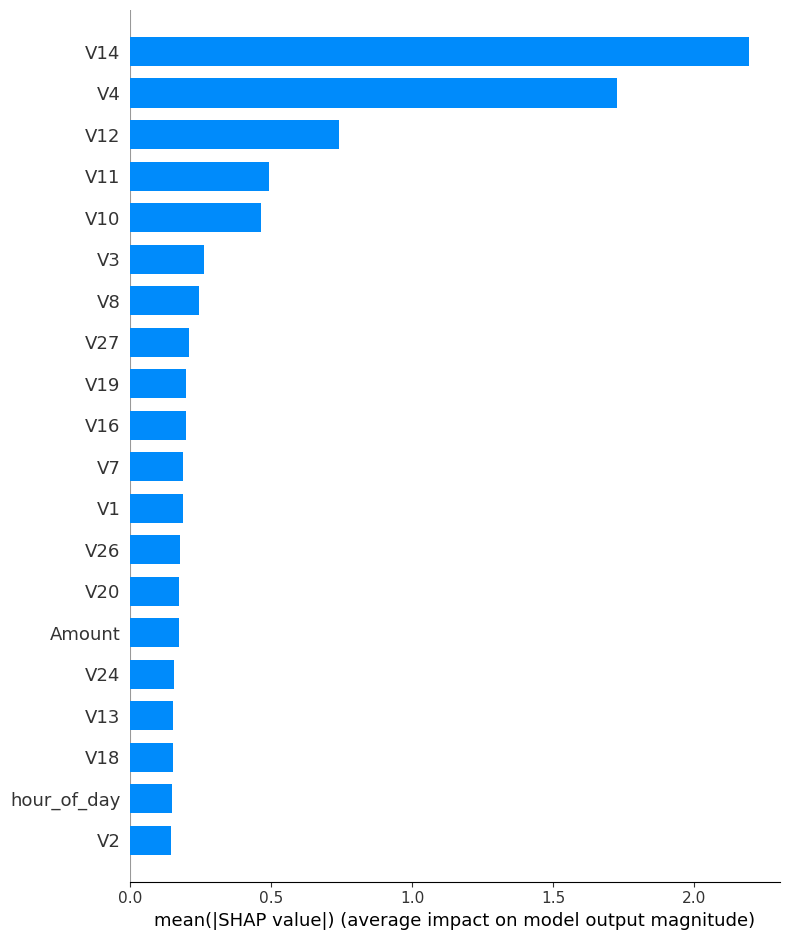

In [65]:
import shap
import matplotlib.pyplot as plt

# TreeExplainer, XGBoost gibi ağaç tabanlı modeller için çok hızlıdır
explainer = shap.TreeExplainer(model)
# Test setinden küçük bir örneklem alalım (hesaplama hızı için)
sample_X = X_test.iloc[:100]
shap_values = explainer.shap_values(sample_X)

# Global Önem Grafiği: Model genel olarak nelere bakıyor?
shap.summary_plot(shap_values, sample_X, plot_type="bar")

## 4. 2. Adım: Lokal Açıklama (Waterfall Plot)

Diyelim ki 5. sıradaki işlem çok riskli çıktı. Neden?

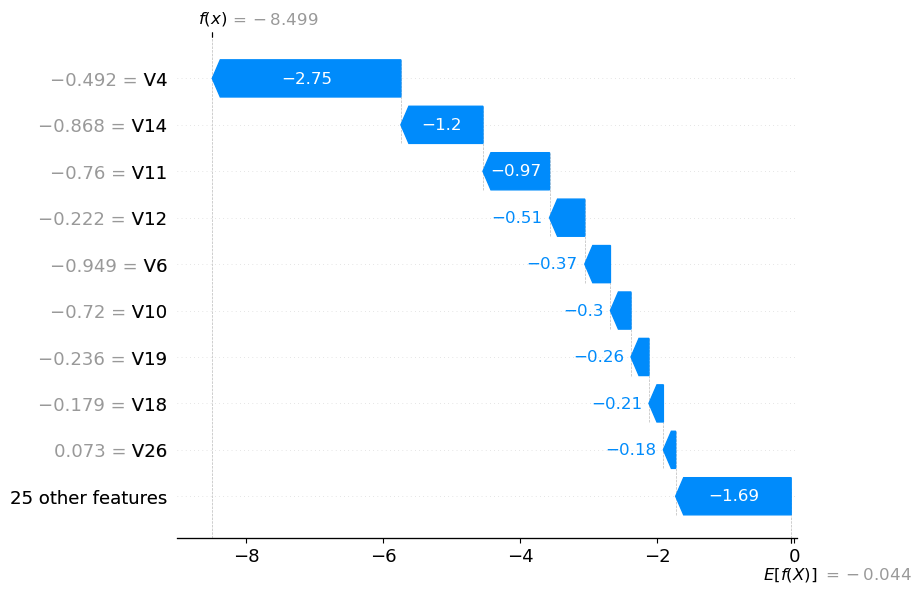

In [68]:
# Belirli bir satırın analizini görselleştirelim
# .base_values: modelin ortalama tahmini
# .values: bu işlem özelindeki etkiler
exp = shap.Explanation(
    values=shap_values[5], 
    base_values=explainer.expected_value, 
    data=sample_X.iloc[5], 
    feature_names=X_test.columns.tolist()
)

shap.plots.waterfall(exp)

## 4.3. Adım: DiCE (Counterfactuals - Ne Olsaydı?)

Bu, modelin sınırlarını test eder. "Tutar 1000$ yerine 10$ olsaydı sistem hala bloklayacak mıydı?" sorusuna yanıt verir.

In [71]:
import dice_ml

# Veriyi DiCE'a uygun formata getiriyoruz
d = dice_ml.Data(dataframe=pd.concat([X_train, y_train], axis=1), 
                continuous_features=X_train.columns.tolist(), 
                outcome_name='Class')

# Modeli tanıtıyoruz
m = dice_ml.Model(model=model, backend="sklearn")
exp = dice_ml.Dice(d, m, method="random")

# Bir Fraud örneği seçelim ve "nasıl temiz olurdu?" diye soralım
query_instance = X_test[y_test == 1].iloc[0:1]
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=2, desired_class=0)

# Sonucu DataFrame olarak göster
dice_exp.visualize_as_dataframe()

100%|██████████| 1/1 [00:09<00:00,  9.01s/it]

Query instance (original outcome : 1)


,Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,hour_of_day,is_night_transaction,amt_to_mean_ratio,is_high_amount,log_amount,Class
0,0.01,-1.271244,2.462675,-2.851395,2.32448,-1.372245,-0.948196,-3.065234,1.166927,-2.268771,...,0.224228,0.756335,0.6328,0.250187,15,0,0.000113,0,0.00995,1



Diverse Counterfactual set (new outcome: 0)


,Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,hour_of_day,is_night_transaction,amt_to_mean_ratio,is_high_amount,log_amount,Class
0,0.01,-1.271244,2.462675,-2.851395,2.32448,-1.372245,-0.948196,-3.065234,1.166927,-2.268771,...,0.224228,0.756335,0.6328,0.250187,15,0,0.000113,0,0.00995,0
1,2050.60,-1.271244,2.462675,-2.851395,2.32448,-1.372245,-0.948196,-3.065234,1.166927,-2.268771,...,0.224228,0.756335,0.6328,0.250187,15,0,0.000113,0,0.00995,0


------------------------

# Faz 5: Servis Katmanı (FastAPI) - Hazırlık

Modelleme bitti, açıklamalar hazır. Şimdi bu modeli bir "ürüne" dönüştürelim. Jupyter'den çıkıp bir .py dosyası yazmaya başlayacağız ama önce notebook'ta son bir işlem yapmalıyız: En iyi modeli diske kaydetmek.

In [73]:
import joblib

# Modeli ve özellik listesini kaydet (API'de kullanacağız)
model_data = {
    'model': model,
    'features': X_train.columns.tolist()
}
joblib.dump(model_data, 'fraud_model_v1.pkl')
print("✅ Model API için 'fraud_model_v1.pkl' olarak kaydedildi!")

✅ Model API için 'fraud_model_v1.pkl' olarak kaydedildi!


Modelimizi eğittik, neye göre karar verdiğini anladık. Şimdi bu modeli bir .pkl dosyası olarak kaydetmiştin. Sırada bu modeli dünyanın her yerinden gelen isteklere cevap verebilecek bir Microservice haline getirmek var.

Bu adımda Jupyter Notebook'tan biraz uzaklaşıp, projenin api/ klasörü için bir Python scripti yazacağız.

## 5.1. Gerekli Kütüphaneler

Terminale şunları kuralım:

!pip install fastapi uvicorn pydantic

## 5.2. API Kodunu Oluşturma (app.py)
Aşağıdaki kodu app.py adıyla bir dosyaya kaydetmeni veya Notebook'ta bir hücreye yazıp dosyaya yazmanı (%%writefile app.py) istiyorum:

In [ ]:
from fastapi import FastAPI
import joblib
import pandas as pd
from pydantic import BaseModel

# 1. Uygulama ve Model Yükleme
app = FastAPI(title="🛡️ FraudGuard Real-Time API")
model_artifacts = joblib.load('fraud_model_v1.pkl')
model = model_artifacts['model']
feature_names = model_artifacts['features']

# 2. Gelen Veri Yapısı (Pydantic Contract)
class TransactionData(BaseModel):
    Amount: float
    V1: float = 0.0
    V2: float = 0.0
    hour_of_day: int = 12
    is_night_transaction: int = 0
    amt_to_mean_ratio: float = 1.0

# 3. Tahmin Endpoint'i
@app.post("/predict")
def predict_fraud(data: TransactionData):
    # JSON verisini DataFrame'e çevir
    input_df = pd.DataFrame([data.dict()])
    
    # Modelin eğitimde gördüğü tüm kolonları kontrol et, eksikleri 0 ile doldur
    for col in feature_names:
        if col not in input_df.columns:
            input_df[col] = 0.0
            
    # Kolon sıralamasını modelin beklediği hale getir
    input_df = input_df[feature_names]
    
    # Tahmin hesapla
    prob = model.predict_proba(input_df)[0][1]
    prediction = 1 if prob > 0.5 else 0
    
    return {
        "fraud_probability": round(float(prob), 4),
        "is_fraud": bool(prediction),
        "status": "Success"
    }

@app.get("/")
def home():
    return {"message": "FraudGuard API is online and protecting transactions!"}

## 5.3. API'yi Ayağa Kaldırma

Normalde terminalde uvicorn app:app --reload yazılır ama sen Jupyter'deysen şu kodla geçici bir sunucu başlatabilirsin:

In [87]:
# NumPy 2.x'i kaldırıp kararlı 1.26 sürümünü kuruyoruz
!pip uninstall -y numpy
!pip install "numpy<2"

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
easyocr 1.7.2 requires opencv-python-headless, which is not installed.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.5 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.5 which is incompatible.


In [89]:
import uvicorn
import nest_asyncio
from app import app # app.py dosyasındaki 'app' nesnesini buraya çağırıyoruz

# Jupyter içinde asenkron çalışmayı sağlar
nest_asyncio.apply()

print("🚀 API başlatılıyor... http://127.0.0.1:8000 adresinden erişebilirsiniz.")
print("⚠️ Not: Bu hücre çalıştığı sürece notebook 'meşgul' görünecektir. Durdurmak için yukarıdaki 'Stop' butonuna basabilirsin.")

# API'yi başlat
uvicorn.run(app, host="127.0.0.1", port=8000)

🚀 API başlatılıyor... http://127.0.0.1:8000 adresinden erişebilirsiniz.
⚠️ Not: Bu hücre çalıştığı sürece notebook 'meşgul' görünecektir. Durdurmak için yukarıdaki 'Stop' butonuna basabilirsin.


RuntimeError: asyncio.run() cannot be called from a running event loop

Yeni bir terminal aç ve tekrar şu komutu ver:

uvicorn app:app --host 127.0.0.1 --port 8000 --reload

Terminalde hata almadan "Running" yazısını gördüysen, Notebook'da altta verdiğim requests kodunu  çalıştır:

In [2]:
import requests

test_payload = {
    "Amount": 1500.0,
    "V1": 0.5,
    "V2": -0.2,
    "hour_of_day": 4, 
    "is_night_transaction": 1,
    "amt_to_mean_ratio": 5.0
}

try:
    response = requests.post("http://127.0.0.1:8000/predict", json=test_payload)
    print("✅ API Başarıyla Cevap Verdi:")
    print(response.json())
except Exception as e:
    print(f"❌ Hala bir sorun var: {e}")

✅ API Başarıyla Cevap Verdi:
{'fraud_probability': 0.0004, 'is_fraud': False}


---------------

## Faz 6: İzleme (Monitoring) Hazırlığı

API çalışıyor, ancak dolandırıcılık dünyası değişkendir. Şimdi son bölüm olan İzleme kısmına geçiyoruz. Burada amacımız, gelen canlı verilerin (API'ye giren veriler) eğitim verimizden sapıp sapmadığını anlamak.

Dolandırıcılar taktik değiştirdiğinde veya ekonomik şartlar değiştiğinde (örneğin enflasyon nedeniyle ortalama harcama tutarları arttığında) modelin kafası karışabilir. Biz buna **Data Drift (Veri Kayması)** diyoruz.

Bu işlemler için diğer Notebook' a geçiniz.. 